### How many different types of speeding citations are there?  How are the different types distributed throughout the day?

#### For this analysis I have narrowed the 'Citations' dataset to only those with a 'Charge Description' that includes the word *Exceed* .  This results in a total of 10,209 observations.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pyodbc
import pandas as pd
import seaborn as sns
import datetime
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.0f}'.format

# databaseConnection = 'DRIVER={SQL Server}; SERVER=ServerName; Database=DatbaseName; UID=UserId; PWD=password;'
connection = pyodbc.connect('DRIVER={SQL Server};SERVER=WINDOWS-A6S01I2\SQLEXPRESS;DATABASE=City_of_Scottsdale;Trusted_Connection=yes;')
cursor = connection.cursor()

# SQL query to import all citation data
speed_citations = '''
  select *
from [dbo].[spd_PDCitations$]
where [Charge Description] like '%exceed%' or 
	[Charge Description] like '%Speed Greater Than R&P or Posted%' or
	[Charge Description] like '%Racing/Exhibition of Speed%'
  '''
speed_citations = pd.read_sql(speed_citations, connection)
connection.close()

speed_citations['Month'] = speed_citations['Citation Date'].dt.month
speed_citations['Day_of_Month'] = speed_citations['Citation Date'].dt.day

speed_citations['Day_of_Week'] = speed_citations['Citation Date']. \
    apply(lambda x: x.strftime('%a')) #format Citation Day to represent day of week(Mon, Tu, Wed, ect.)

speed_citations['Hour_of_Day'] = speed_citations['Citation Time']. \
    apply(lambda x: str(x)[-7:-4]) # extract the hour of the day from the datetime column

speed_citations['Hour_of_Day'] = pd.to_numeric(speed_citations['Hour_of_Day'],errors='coerce')

#exclude handful of people with gender not M or F
# speed_citations = speed_citations[speed_citations['Cited Person Sex'] != 'U']

In [4]:
speed_citations.head()

,tcmainid,Citation #,Citation Date,Citation Time,Arizona Statute Code,Charge Description,Citation Type Code,Citation Type Description,Officer Badge #,Street Number,Street,City,State,Zip,District,Beat,Zone,Cited Person,Cited Person Age,Cited Person Race,Cited Person Sex,Cited Person Ethnicity,Month,Day_of_Month,Day_of_Week,Hour_of_Day
0,621983,2056417,2018-06-20,2053,28-701A,Speed Greater Than R&P or Posted,CV,Civil Traffic,1202,5xxx,N Scottsdale Rd,Scottsdale,AZ,nan,D2,8,2201,"San, Felix",57,B,M,U,6,20,Wed,20
1,622034,8083673,2018-06-22,823,28-701A,Speed Greater Than R&P or Posted,CV,Civil Traffic,874,6xxx,E McDowell Rd,Scottsdale,AZ,nan,D1,4,402,"Ochoa-Mendoza, Maritza",28,W,F,U,6,22,Fri,8
2,622159,2063956,2018-06-21,2020,28-701A,Speed Greater Than R&P or Posted,CV,Civil Traffic,1492,xxx,N Pima Crossing / E Shea Bl,Scottsdale,AZ,nan,D3,11,2907,"Vanatta, Lauren",21,W,F,N,6,21,Thu,20
3,622161,2060088,2018-06-21,1410,28-701A,Speed Greater Than R&P or Posted,CV,Civil Traffic,1180,xxx,N Hayden Rd / E Juan Tabo Rd,Scottsdale,AZ,nan,D4,19,4001,"Groat, Diana",60,W,F,N,6,21,Thu,14
4,593351,2047026,2017-10-21,1403,28-701A,Speed Greater Than R&P or Posted,CV,Civil Traffic,1382,7xxx,E Indian Bend Rd,Scottsdale,AZ,nan,D3,9,2401,"Rotter, Frank",58,W,M,U,10,21,Sat,14


In [5]:
speed_citations.dtypes

tcmainid                            float64
Citation #                          float64
Citation Date                datetime64[ns]
Citation Time                       float64
Arizona Statute Code                 object
Charge Description                   object
Citation Type Code                   object
Citation Type Description            object
Officer Badge #                     float64
Street Number                        object
Street                               object
City                                 object
State                                object
Zip                                 float64
District                             object
Beat                                float64
Zone                                float64
Cited Person                         object
Cited Person Age                    float64
Cited Person Race                    object
Cited Person Sex                     object
Cited Person Ethnicity               object
Month                           

In [81]:
speed_citations.shape

(10209, 26)

In [57]:
speeding_by_hr_day = speed_citations.groupby(['Hour_of_Day', 'Charge Description'])['Charge Description'] \
    .count().unstack().reset_index()

speeding_by_hr_day_long = pd.melt(speeding_by_hr_day, id_vars='Hour_of_Day')
speeding_by_hr_day_long.head()

,Hour_of_Day,Charge Description,value
0,1,Exceed 15mph In School Crossing,nan
1,2,Exceed 15mph In School Crossing,nan
2,3,Exceed 15mph In School Crossing,nan
3,4,Exceed 15mph In School Crossing,nan
4,5,Exceed 15mph In School Crossing,nan


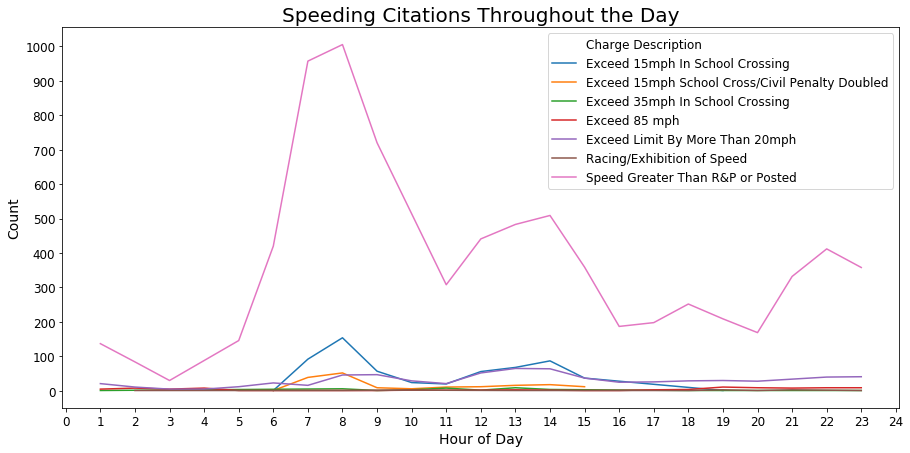

In [90]:
plt.rcParams["figure.figsize"] = [15, 7]

ax = sns.lineplot(x="Hour_of_Day", \
                  y="value", \
                  hue="Charge Description", \
                  data=speeding_by_hr_day_long)

plt.title("Speeding Citations Throughout the Day",fontsize=20)
plt.xlabel("Hour of Day",fontsize=14)
plt.ylabel("Count",fontsize=14)
plt.tick_params(labelsize=12)
plt.legend(fontsize=12)

ax.xaxis.set_major_locator(ticker.MultipleLocator())
ax.yaxis.set_major_locator(ticker.MultipleLocator(100))

### Results: The vast majority of basic speeding citations take place in the morning, with a smaller number in the afternoon as people return from work.

In [88]:
# because of the excessive volume of citations in
# category "Speed Greater Than R&P or Posted" I'm excluding that from the next graph

speed_citations_smaller_quantity = speed_citations[speed_citations['Charge Description'] != 'Speed Greater Than R&P or Posted']

speed_citations_smaller_quantity_hr_day = speed_citations_smaller_quantity \
    .groupby(['Hour_of_Day', 'Charge Description'])['Charge Description'] \
    .count().unstack().reset_index()

speed_citations_smaller_quantity_hr_day_long = pd \
    .melt(speed_citations_smaller_quantity_hr_day, id_vars='Hour_of_Day')

speed_citations_smaller_quantity_hr_day_long.head()

,Hour_of_Day,Charge Description,value
0,1,Exceed 15mph In School Crossing,nan
1,2,Exceed 15mph In School Crossing,nan
2,3,Exceed 15mph In School Crossing,nan
3,4,Exceed 15mph In School Crossing,nan
4,5,Exceed 15mph In School Crossing,nan


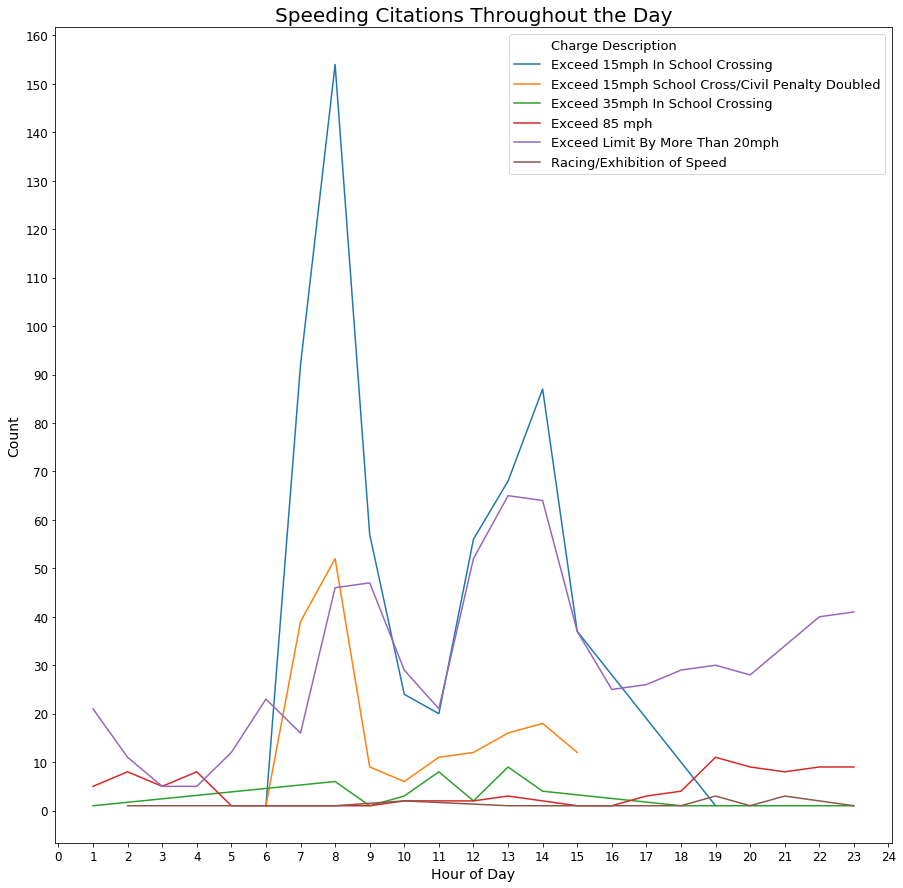

In [84]:
plt.rcParams["figure.figsize"] = [15, 15]

ax = sns.lineplot(x="Hour_of_Day", \
                  y="value", \
                  hue="Charge Description", \
                  data=speed_citations_smaller_quantity_hr_day_long)

plt.title("Speeding Citations Throughout the Day",fontsize=20)
plt.xlabel("Hour of Day",fontsize=14)
plt.ylabel("Count",fontsize=14)
plt.tick_params(labelsize=12)
plt.legend(fontsize=13)

ax.xaxis.set_major_locator(ticker.MultipleLocator())
ax.yaxis.set_major_locator(ticker.MultipleLocator(10))

### Results: Although most speeding citations occur in the first half of the day, the following citations occur more frequently in the latter half of the day.
### + Exceeding Limit by More the 20mph 
### + Exceed 85 mph
### + Racing/Exhibition of Speed